## Test: Another Method of Calculating Lensed Ellipticity for BCGs

### Aidan Cloonan

### August 2020

Now with Dask dataframes! In testing, this appeared to work much more efficiently (less memory, less time) than GCRCatalogs. I'll be looking into applying a similar method for extracting comoving Cartesian coordinates as I use here.

Note that for most redMaPPer clusters, the member galaxy most likely to be the BCG is labeled as `id_cen_0`.

In [1]:
# math, array manipulation, etc.
import numpy as np
import esutil                    # must use desc-stack kernel

# get central galaxy/BCG and cluster member data
import GCRCatalogs as gcr

# astropy
import astropy.io.fits as fits                     # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM        # making cosmological calculations
from astropy import units as u                     # units
from astropy.table import Table                    # Table data structure

# for timing loops 
from tqdm import *
import time

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# opening and extracting data from HDF5 files
import os
import h5py

# dask data structures, pandas operations, etc.
import dask as da
import dask.dataframe as dd

### Compile Cluster Data

In [2]:
# redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [3]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)

# these are the quantities that describe what are likely the BCGs
bcg_quantities = [q for q in cluster_quantities if 'cen_0' in q] + ['cluster_id']
print("\nBCG quantities:\n")
print(bcg_quantities)

All redMaPPer quantities:

['ra_cen_3', 'magerr_i_lsst_member', 'ra_cen_0', 'id_member', 'p_member', 'dec', 'theta_i_member', 'id_cen_4', 'magerr_r_lsst_member', 'mag_y_lsst_member', 'magerr_z_lsst_member', 'cluster_id_member', 'magerr_g_lsst_member', 'id_cen_0', 'p_cen_4', 'redshift_true_member', 'dec_cen_3', 'id_cen_1', 'scaleval', 'mag_r_lsst_member', 'id_cen_3', 'magerr_y_lsst_member', 'ra_member', 'dec_cen_1', 'redshift', 'richness', 'refmag_member', 'refmag_err_member', 'ra', 'redshift_err', 'p_cen_0', 'ra_cen_1', 'dec_cen_2', 'redshift_true_cg', 'id_cen_2', 'p_cen_3', 'dec_cen_4', 'dec_cen_0', 'ra_cen_2', 'dec_member', 'richness_err', 'ra_cen_4', 'p_cen_2', 'mag_z_lsst_member', 'p_cen_1', 'mag_g_lsst_member', 'theta_r_member', 'cluster_id', 'pfree_member', 'mag_i_lsst_member', 'maskfrac']

Cluster quantities:

['ra_cen_3', 'ra_cen_0', 'dec', 'id_cen_4', 'id_cen_0', 'p_cen_4', 'dec_cen_3', 'id_cen_1', 'scaleval', 'id_cen_3', 'dec_cen_1', 'redshift', 'richness', 'ra', 'redshift_er

In [4]:
# get cluster data
redM_data = Table(redM_gcr.get_quantities(cluster_quantities))

# extract BCG data and BCG IDs
bcg_data = redM_data[bcg_quantities]
bcg_ids = redM_data['id_cen_0']
bcg_data

ra_cen_0,id_cen_0,p_cen_0,dec_cen_0,cluster_id
float64,int64,float32,float64,int32
52.520436430812914,1312945563,0.7840171,-25.717996124671657,12
52.67840938259691,1313040661,0.9999995,-25.63184326314064,154
53.81457486617126,1312581703,0.726603,-26.552357796399047,385
52.24966756483943,1312509606,0.7799704,-25.97730838369064,501
53.92820091867718,1314220475,0.9994414,-25.25995999463154,466
52.940786054153854,1312872294,0.9421399,-26.077918984346976,840
54.048892077961746,1313133021,0.99995285,-26.36437651092295,1722
53.61812432952921,1312937849,0.9928792,-27.049272624733792,1768
53.79205416824982,1312613261,0.9984934,-25.12706714784822,1976


### Compile Lensing Quantities

All cosmoDC2 galaxy IDs found in the HDF5 files are unique IDs, so we can apply the same method for extracting all quantities.

In [5]:
# define a function that compiles a dask array of all cosmoDC2 data points
def compile_one_quantity(quantity, path):
    '''
    This function loops through all HDF5 files in a given directory, extracting all data
    for a given quantity, and appending that data to a list of dask arrays. Then, all
    arrays are concatenated into a 1D array, which serves as the output.
    
    Inputs:
    
        quantity        |
        
        path            |
        
    Output:
    
        total_con       |
    '''
    # empty list, dask arrays will be appended to it
    da_arr_lst = []
    
    print("Compiling data...")
    
    # now, iterate through all files to get IDs
    for hf in tqdm(os.listdir(path)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(path, hf)
        open_file = h5py.File(datafile)
        
        # compile IDs for that file
        file_data = open_file[quantity]
        
        # convert data to dask arrays
        da_arr_data = da.array.from_array(file_data)
        
        # append dask array to list
        da_arr_lst.append(da_arr_data)
        
        #open_file.close()
        
    # combine the IDs from the dask arrays into one shape
    total_con = da.array.concatenate(da_arr_lst, axis=0)
    
    print("Done!")
    print("We have {} galaxies in the dataset.".format(total_con.shape[0]))
    
    # return this 1D array
    return total_con

In [6]:
# define path to cosmoDC2 HDF5 files
path = '/global/cfs/projectdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_rs_scatter_query_tree_double'

In [7]:
# now, let's get all galaxy IDs in cosmoDC2
all_galaxy_ids_con = compile_one_quantity('galaxyProperties/galaxyID', path)

  0%|          | 1/393 [00:00<01:35,  4.12it/s]

Compiling data...


100%|██████████| 393/393 [00:57<00:00,  6.82it/s]

Done!
We have 2256249331 galaxies in the dataset.


In [86]:
# make a dask dataframe out of our galaxy ID array
# not all IDs in cosmoDC2 are BCGs (cen_0) but I'm using that column name to emphasize
# that new quantities resulting from dd.merge apply only to our BCGs
all_galaxies_dd = dd.from_array(all_galaxy_ids_con, columns=['id_cen_0'])

In [50]:
# add indices to dd, to see if it works
all_galaxies_dd['total_dask_index'] = all_galaxy_ids_dd.index

### Test: Calculating Ellipticity from Other Quantities

In [30]:
# now, lets repeat our extraction process for all other lensing quantities
# first, shear1
all_shear1_con = compile_one_quantity('galaxyProperties/shear1', path)

  1%|▏         | 5/393 [00:00<00:11, 33.68it/s]

Compiling data...


100%|██████████| 393/393 [00:05<00:00, 70.99it/s]

Done!
We have 2256249331 galaxies in the dataset.


In [31]:
# shear2
all_shear2_con = compile_one_quantity('galaxyProperties/shear2', path)

  5%|▍         | 19/393 [00:00<00:01, 187.95it/s]

Compiling data...


100%|██████████| 393/393 [00:02<00:00, 176.03it/s]

Done!
We have 2256249331 galaxies in the dataset.


In [70]:
# ellipticity_1
all_e1_con = compile_one_quantity('galaxyProperties/morphology/totalEllipticity1'
                                  , path)

  3%|▎         | 11/393 [00:00<00:06, 57.99it/s]

Compiling data...


100%|██████████| 393/393 [00:04<00:00, 85.61it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [71]:
# ellipticity_2
all_e2_con = compile_one_quantity('galaxyProperties/morphology/totalEllipticity2'
                                  , path)

  4%|▍         | 15/393 [00:00<00:03, 104.30it/s]

Compiling data...


100%|██████████| 393/393 [00:09<00:00, 42.90it/s]

Done!
We have 2256249331 galaxies in the dataset.


In [72]:
# finally, convergence
all_convergence_con = compile_one_quantity('galaxyProperties/convergence'
                                           , path)

  0%|          | 0/393 [00:00<?, ?it/s]

Compiling data...


100%|██████████| 393/393 [00:12<00:00, 31.22it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [87]:
# make sure the galaxies dataframe is the same
all_galaxies_dd = dd.from_array(all_galaxy_ids_con, columns=['id_cen_0'])

# compile quantities, and also make the process non-destructive
test_calc_e_all_gal_dd = all_galaxies_dd
test_calc_e_all_gal_dd['shear1_cen_0'] = all_shear1_con
test_calc_e_all_gal_dd['shear2_cen_0'] = all_shear2_con
test_calc_e_all_gal_dd['ellipticity_1_cen_0'] = all_e1_con
test_calc_e_all_gal_dd['ellipticity_2_cen_0'] = all_e2_con
test_calc_e_all_gal_dd['convergence_cen_0'] = all_convergence_con

In [88]:
for i in test_calc_e_all_gal_dd:
    print(i)

id_cen_0
shear1_cen_0
shear2_cen_0
ellipticity_1_cen_0
ellipticity_2_cen_0
convergence_cen_0


### Test: Extract Ellipticity

In [34]:
# TEST: total ellipticity
all_total_e_con = compile_one_quantity('galaxyProperties/morphology/totalEllipticity'
                                        , path)

  1%|          | 3/393 [00:00<00:37, 10.48it/s]

Compiling data...


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


Done!
We have 2256249331 galaxies in the dataset.


In [109]:
# make sure the galaxies dataframe is the same
all_galaxies_dd = dd.from_array(all_galaxy_ids_con, columns=['id_cen_0'])

# compile total ellipticity, and also make the process non-destructive
test_e_all_gal_dd = all_galaxies_dd
test_e_all_gal_dd['extracted_ellipticity_cen_0'] = all_total_e_con

### Convert BCG Table to Dask Dataframe

In [110]:
for col in test_e_all_gal_dd:
    print(col)

id_cen_0
extracted_ellipticity_cen_0


In [38]:
# set up dask arrays for BCG data

bcg_da_lst = []
q_lst = []

for q in bcg_quantities:
    q_lst.append(q)
    bcg_da = da.array.from_array(bcg_data[q])
    bcg_da_lst.append(bcg_da)

In [39]:
# make multi-dimensional dask array
bcg_all_q_da = da.array.from_array(bcg_da_lst)

In [40]:
# invert dimensions
bcg_all_q_da_tp = bcg_all_q_da.transpose()
print(bcg_all_q_da.shape)
print(bcg_all_q_da_tp.shape)

(5, 3895)
(3895, 5)


In [42]:
# convert to dataframe
bcg_all_q_dd = dd.from_array(bcg_all_q_da_tp, columns=q_lst)

In [80]:
# make sure our ID is still an integer (it might have gotten converted to a float)
for q in bcg_quantities:
    if 'id' in q:
        bcg_all_q_dd[q] = bcg_all_q_dd[q].astype(np.int64)
bcg_all_q_dd.compute()

,id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id
0,1312945563,-25.717996,52.520436,0.784017,12
1,1313040661,-25.631843,52.678409,1.000000,154
2,1312581703,-26.552358,53.814575,0.726603,385
3,1312509606,-25.977308,52.249668,0.779970,501
4,1314220475,-25.259960,53.928201,0.999441,466
5,1312872294,-26.077919,52.940786,0.942140,840
6,1313133021,-26.364377,54.048892,0.999953,1722
7,1312937849,-27.049273,53.618124,0.992879,1768
8,1312613261,-25.127067,53.792054,0.998493,1976
9,1313648793,-26.998701,53.675975,0.958533,2045


### Merging

#### Calculated Ellipticity

In [89]:
# merge the two dataframes
merged_calc_e_dd = dd.merge(bcg_all_q_dd, test_calc_e_all_gal_dd, on='id_cen_0')

In [90]:
# compute result
test_calc_e_merged_dd_compute = merged_calc_e_dd.compute()

In [91]:
test_calc_e_merged_dd_compute

,id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id,shear1_cen_0,shear2_cen_0,ellipticity_1_cen_0,ellipticity_2_cen_0,convergence_cen_0
0,3627524376,-30.783421,68.991698,0.999882,1307,-0.010508,0.001818,0.037046,-0.172724,-0.011485
1,3627513653,-30.971352,68.942238,0.995500,1719,-0.012316,-0.005494,0.036684,-0.038829,-0.005793
2,3628079457,-29.291576,68.353155,0.510638,2586,-0.026027,0.001884,0.006559,-0.015478,-0.012765
0,9126933455,-38.680347,74.299463,1.000000,30,0.007005,0.007552,0.037603,-0.080186,0.045673
1,9126023181,-38.773005,74.116558,0.999999,52,-0.003442,0.000586,-0.103065,0.007955,-0.008484
2,9125862976,-38.432121,73.685444,0.999954,114,-0.002575,0.007204,-0.004756,-0.005905,0.004707
3,9125635268,-40.164157,74.486582,0.999294,136,0.003316,-0.001363,-0.007780,0.016345,0.000303
4,9126336864,-38.779864,73.775593,0.984524,631,0.000292,-0.011534,0.000082,0.003277,-0.013720
5,9126332131,-38.703823,74.505484,0.999867,632,-0.000912,0.006658,-0.006939,-0.018717,-0.011387
6,9127198230,-38.332672,75.289735,0.966895,804,-0.011266,-0.001980,-0.044457,0.099870,-0.004257


In [104]:
# convert to an astropy table
test_calc_e_merged_table = Table.from_pandas(test_calc_e_merged_dd_compute)

In [105]:
# now, let's define a function to find lensed ellipticity
def calc_lensed_ellipticity(gamma1, gamma2, e_t1, e_t2, kappa):
    '''
    This function utilizes relations between shear, convergence, and the true ellipticity 1 and 2 values in order to
    calculate the lensed ellipticity.
    
    Inputs:
        
        gamma1             |    The quantity 'shear_1'
        
        gamma2             |    The quantity 'shear_2'
        
        e_t1               |    The quantity 'ellipticity_1_true'
        
        e_t2               |    The quantity 'ellipticity_2_true'
        
        kappa              |    The quantity 'convergence'
        
    Output:
    
        np.abs(e)          |    The absolute value of the complex number e, as calculated below. Note that the
                                absolute value of a complex number, a + b*1j, is found with (a**2 + b**2) ** 0.5.
                                This is the distance formula on the complex plane from the origin to the plotted
                                complex number.
    '''
    gamma = gamma1 + gamma2*1j                     # shear (as a complex number, note that 1j is the imaginary number)
    e_t = e_t1 + e_t2*1j                           # true or intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa)                      # reduced shear
    e = (e_t + g) / (1.0 + (e_t * g.conjugate()))  # lensed ellipticity
    
    # return lensed ellipticity
    return np.abs(e)

In [106]:
# extract lensing parameters
test_bcg_shear1 = test_calc_e_merged_table['shear1_cen_0']
test_bcg_shear2 = test_calc_e_merged_table['shear2_cen_0']
test_bcg_e1 = test_calc_e_merged_table['ellipticity_1_cen_0']
test_bcg_e2 = test_calc_e_merged_table['ellipticity_2_cen_0']
test_bcg_kappa = test_calc_e_merged_table['convergence_cen_0']

In [107]:
# calculate ellipticity for BCGs
test_calc_e_merged_table['calc_ellipticity_cen_0'] = calc_lensed_ellipticity(test_bcg_shear1
                                                                        , test_bcg_shear2
                                                                        , test_bcg_e1
                                                                        , test_bcg_e2
                                                                        , test_bcg_kappa)

In [112]:
test_calc_e_merged_table[np.where(test_calc_e_merged_table['id_cen_0'] == 3627513653)]

id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id,shear1_cen_0,shear2_cen_0,ellipticity_1_cen_0,ellipticity_2_cen_0,convergence_cen_0,calc_ellipticity_cen_0
int64,float64,float64,float64,int64,float64,float64,float32,float32,float64,float64
3627513653,-30.97135189836122,68.94223764591693,0.9955004453659058,1719,-0.012316455299118234,-0.005493916272961776,0.03668407,-0.03882872,-0.005792776786713416,0.05059790209131834


In [113]:
test_calc_e_merged_table

id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id,shear1_cen_0,shear2_cen_0,ellipticity_1_cen_0,ellipticity_2_cen_0,convergence_cen_0,calc_ellipticity_cen_0
int64,float64,float64,float64,int64,float64,float64,float32,float32,float64,float64
3627524376,-30.783420682145405,68.99169830206984,0.9998818635940552,1307,-0.010508461526824942,0.001817984352945032,0.037045542,-0.17272355,-0.011484763738711212,0.17311239454716876
3627513653,-30.97135189836122,68.94223764591693,0.9955004453659058,1719,-0.012316455299118234,-0.005493916272961776,0.03668407,-0.03882872,-0.005792776786713416,0.05059790209131834
3628079457,-29.29157582157445,68.35315467533017,0.510638415813446,2586,-0.02602721860157653,0.0018838598776035741,0.0065592728,-0.015477877,-0.01276543919175932,0.023494604109315698
9126933455,-38.68034692578836,74.29946327467562,1.0,30,0.007005459077540632,0.007551738614799481,0.03760283,-0.080185704,0.04567267696010968,0.08513774445250527
9126023181,-38.77300515053466,74.11655820445759,0.9999988675117493,52,-0.0034421236937247635,0.0005863654991959903,-0.1030647,0.007955129,-0.008483929470099127,0.10678145960822177
9125862976,-38.43212085001903,73.68544358473187,0.9999544620513916,114,-0.0025745344914036017,0.007204034059542251,-0.0047563068,-0.005905106,0.004706980095420477,0.007463254609650743
9125635268,-40.16415736485881,74.48658187638912,0.999294102191925,136,0.0033159409447305332,-0.001363043715177812,-0.0077801286,0.016344784,0.0003033696627445792,0.01563277442156469
9126336864,-38.77986350917909,73.7755930181362,0.9845236539840698,631,0.0002923351563991483,-0.0115335875352018,8.163239e-05,0.003276574,-0.013719509000727825,0.008109667839766476
9126332131,-38.70382291449209,74.50548360054299,0.99986732006073,632,-0.0009118317111477259,0.006657903095039729,-0.0069386796,-0.018716836,-0.011387270083766943,0.01444817199017272


#### Extracted Ellipticity

In [53]:
# merge the two dataframes
merged_e_dd = dd.merge(bcg_all_q_dd, test_e_all_gal_dd, on='id_cen_0')

In [102]:
# let's look at our result
test_e_merged_dd_compute = merged_e_dd.compute()

In [103]:
test_e_merged_dd_compute

,id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id,total_dask_index,total_ellipticity_cen_0
0,3627524376,-30.783421,68.991698,0.999882,1307,24376,0.176652
1,3627513653,-30.971352,68.942238,0.995500,1719,13653,0.053417
2,3628079457,-29.291576,68.353155,0.510638,2586,579457,0.016810
0,9126933455,-38.680347,74.299463,1.000000,30,16752436,0.088565
1,9126023181,-38.773005,74.116558,0.999999,52,15842163,0.103371
2,9125862976,-38.432121,73.685444,0.999954,114,15681958,0.007582
3,9125635268,-40.164157,74.486582,0.999294,136,15454250,0.018102
4,9126336864,-38.779864,73.775593,0.984524,631,16155845,0.003278
5,9126332131,-38.703823,74.505484,0.999867,632,16151112,0.019962
6,9127198230,-38.332672,75.289735,0.966895,804,17017211,0.109318


In [68]:
# convert to an astropy table
test_e_merged_table = Table.from_pandas(test_e_merged_dd_compute)

In [97]:
test_e_merged_table[np.where(test_e_merged_table['id_cen_0'] == 3627524376)]

id_cen_0,dec_cen_0,ra_cen_0,p_cen_0,cluster_id,total_dask_index,total_ellipticity_cen_0
int64,float64,float64,float64,int64,int64,float32
3627524376,-30.783420682145405,68.99169830206984,0.9998818635940552,1307,24376,0.17665163


### Comparing the Two

In [111]:
# extract the ellipticity from both tables
test_e = test_e_merged_table['total_ellipticity_cen_0']
test_calc_e = test_calc_e_merged_table['calc_ellipticity_cen_0']

In [140]:
# now, let's find indices where there is a difference above some limit between the two

# find differences in ellipticity
e_diffs = test_e - test_calc_e

# set constraint on e_diff values considered
e_diff_lim = 0.01

# now, grab our e_diff values and indices where np.abs(e_diff) > e_diff_lim
high_e_diffs = [e_diff for i, e_diff in enumerate(e_diffs) if np.abs(e_diff) > e_diff_lim]
high_e_diff_ind = [i for i, e_diff in enumerate(e_diffs) if np.abs(e_diff) > e_diff_lim]

In [185]:
len(high_e_diffs)

609

The mean difference in ellipticity measurements is -0.0011457387691402045
The median difference in ellipticity measurements is -0.0005319162377533295
The standard deviation of e_diffs is 0.008018796673344798


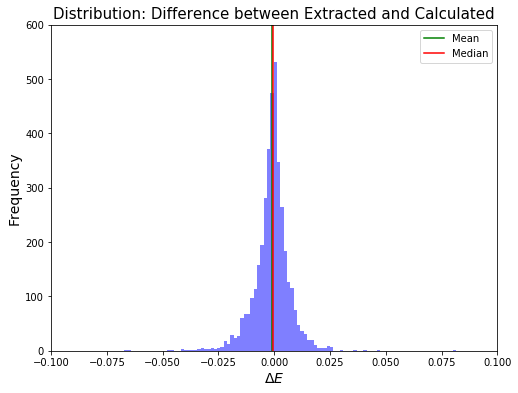

In [228]:
# let's plot the distribution of e_diffs

# get some distribution statistics
e_diff_mean = np.mean(e_diffs)
e_diff_med = np.median(e_diffs)
e_diff_stdev = np.std(e_diffs)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + e_diff_mean
x_med = 0*y + e_diff_med
x_1sigma = 0*y + e_diff_stdev
x_2sigma = 0*y + 2*e_diff_stdev
x_3sigma = 0*y + 3*e_diff_stdev

print("The mean difference in ellipticity measurements is", e_diff_mean)
print("The median difference in ellipticity measurements is", e_diff_med)
print("The standard deviation of e_diffs is", e_diff_stdev)

# histogram

plt.figure(figsize=(8,6))
plt.hist(e_diffs, bins=100, alpha=0.5, color='b')

plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
'''
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

plt.legend(loc='best')
plt.xlabel(r'$\Delta E$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(-.1, .1)
plt.ylim(0,600)

plt.title('Distribution: Difference between Extracted and Calculated', fontsize=15)
plt.show()

Note that $E$ is referring to lensed ellipticity. $\Delta E$ is defined as:

$\Delta E = E_{\rm extracted} - E_{\rm calculated}$. 

Clearly, we can see a seemingly very Normal and Gaussian distribution. The standard deviation, $\sigma_{\Delta E} \approx 0.008$, indicates that most of the differences in ellipticity are very small. So, this might be on the right track. I'll need to ask around to see if one is more trustworthy though. Or maybe if I should be using GCRCatalogs instead. Soon, let's compare the differences between one or both of these methods and the GCR calculations. (Remember I have a FITS file!!)

### Comparing GCRCatalogs Results to these Two Methods

There were slight differences in the calculations between the two Dask tables. Now, let's compare the results from the GCR table with both of them.

In [186]:
# open our new FITS file
bcg_hdu = fits.open('../fits_files/bcg_lensed_data_with_lensed_ellipticity_cosmoDC2_redM.fits')

# extract dataset
bcg_table = Table(bcg_hdu[1].data)

We have two fairly small tables (~3900 indices), so we can just use `esutil` to make sure our indices align.

In [209]:
# find where indices from two tables match
gcr_ind, dask_ind = esutil.numpy_util.match(bcg_table['galaxy_id'] 
                                               , test_e_merged_table['id_cen_0']
                                              )

In [227]:
# reorganize bcg_table so indices match
reorg_bcg_table = bcg_table[gcr_ind]

In [204]:
# check that IDs align
for ind, ID in tqdm(enumerate(reorg_bcg_table['galaxy_id'])):
    time.sleep(0.001)
    assert ID == test_e_merged_table['id_cen_0'][ind]

3895it [00:04, 851.11it/s]


#### GCR vs. Extracted Ellipticity

In [222]:
# find e_diffs
e_diffs_gcr_extr = reorg_bcg_table['ellipticity'] - test_e_merged_table['total_ellipticity_cen_0']

The mean difference in ellipticity measurements is 0.0013616087857674438
The median difference in ellipticity measurements is 0.0007690009137432119
The standard deviation of e_diffs is 0.008092727175862962


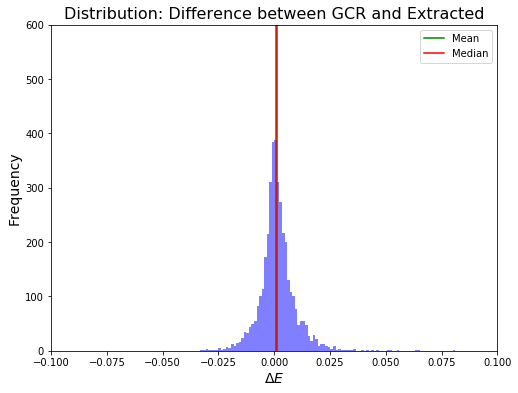

In [230]:
# get some distribution statistics
e_diff_mean = np.mean(e_diffs_gcr_extr)
e_diff_med = np.median(e_diffs_gcr_extr)
e_diff_stdev = np.std(e_diffs_gcr_extr)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + e_diff_mean
x_med = 0*y + e_diff_med
x_1sigma = 0*y + e_diff_stdev
x_2sigma = 0*y + 2*e_diff_stdev
x_3sigma = 0*y + 3*e_diff_stdev

print("The mean difference in ellipticity measurements is", e_diff_mean)
print("The median difference in ellipticity measurements is", e_diff_med)
print("The standard deviation of e_diffs is", e_diff_stdev)

# histogram

plt.figure(figsize=(8,6))
plt.hist(e_diffs_gcr_extr, bins=100, alpha=0.5, color='b')

plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
'''
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

plt.legend(loc='best')
plt.xlabel(r'$\Delta E$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(-.1, .1)
plt.ylim(0,600)

plt.title('Distribution: Difference between GCR and Extracted', fontsize=16)
plt.show()

Note that in the above graph, $\Delta E = E_{\rm GCR} - E_{\rm extracted}$.

#### GCR vs. Calculated

In [224]:
# find e_diffs
e_diffs_gcr_calc = reorg_bcg_table['ellipticity'] - test_calc_e_merged_table['calc_ellipticity_cen_0']

The mean difference in ellipticity measurements is 0.00021587001662723952
The median difference in ellipticity measurements is 2.6831359964743506e-05
The standard deviation of e_diffs is 0.010288006918058284


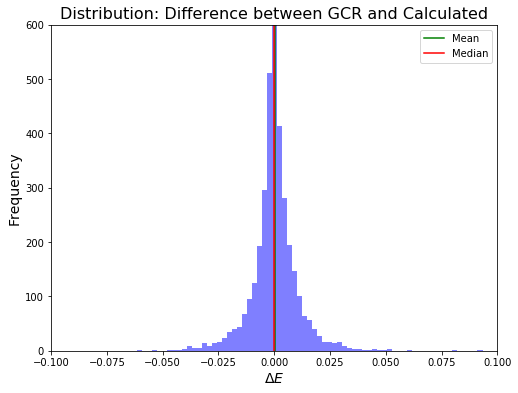

In [232]:
# get some distribution statistics
e_diff_mean = np.mean(e_diffs_gcr_calc)
e_diff_med = np.median(e_diffs_gcr_calc)
e_diff_stdev = np.std(e_diffs_gcr_calc)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + e_diff_mean
x_med = 0*y + e_diff_med
x_1sigma = 0*y + e_diff_stdev
x_2sigma = 0*y + 2*e_diff_stdev
x_3sigma = 0*y + 3*e_diff_stdev

print("The mean difference in ellipticity measurements is", e_diff_mean)
print("The median difference in ellipticity measurements is", e_diff_med)
print("The standard deviation of e_diffs is", e_diff_stdev)

# histogram

plt.figure(figsize=(8,6))
plt.hist(e_diffs_gcr_calc, bins=100, alpha=0.5, color='b')

plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
'''
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

plt.legend(loc='best')
plt.xlabel(r'$\Delta E$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(-.1, .1)
plt.ylim(0,600)

plt.title('Distribution: Difference between GCR and Calculated', fontsize=16)
plt.show()

Note that in the above graph, $\Delta E = E_{\rm GCR} - E_{\rm calculated}$.

It doesn't seem like there is a large statistical difference between any of the 3 methods, based on the distributions of $\Delta E$. The issue with this method, though, is that we can't see how individual data points compare with each other. Let's try 

#### Attempt at Comparing All 3

As of now, I have 2 graphs for this.

I'll set the $P_{\rm BCG}$ (`p_cen_0`) values as the $y$-axis. $E_{\rm extracted} - E_{\rm calculated}$ will be the $x$-axis. For each of the 2 graphs, I'll set the color bar to one of the other two $\Delta E$ arrays.

The mean difference in dask ellipticity measurements is -0.0011457387691402045
The median difference in dask ellipticity measurements is -0.0005319162377533295
The standard deviation of dask e_diffs is 0.008018796673344798


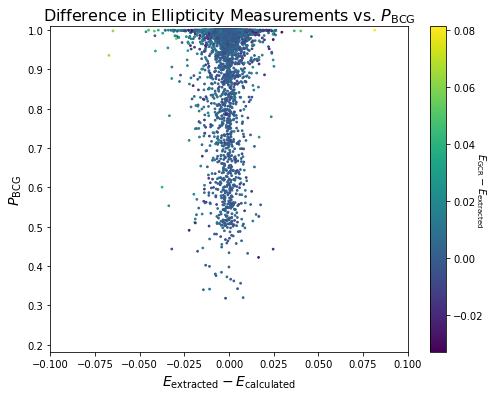

In [252]:
# get some distribution statistics
e_diff_mean = np.mean(e_diffs)
e_diff_med = np.median(e_diffs)
e_diff_stdev = np.std(e_diffs)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + e_diff_mean
x_med = 0*y + e_diff_med
x_1sigma = 0*y + e_diff_stdev
x_2sigma = 0*y + 2*e_diff_stdev
x_3sigma = 0*y + 3*e_diff_stdev

print("The mean difference in dask ellipticity measurements is", e_diff_mean)
print("The median difference in dask ellipticity measurements is", e_diff_med)
print("The standard deviation of dask e_diffs is", e_diff_stdev)

# with E_gcr - E_extracted as colorbar

plt.figure(figsize=(8,6))
plt.scatter(e_diffs
            , test_e_merged_table['p_cen_0']
            , c=e_diffs_gcr_extr
            , cmap='viridis'
            , s=3)

'''
plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

#plt.legend(loc='lower right')
plt.xlabel(r'$E_{\rm extracted} - E_{\rm calculated}$', fontsize=14)
plt.ylabel(r'$P_{\rm BCG}$', fontsize=14)
plt.xlim(-.1, .1)
plt.ylim(0.18, 1.01)

plt.title(r'Difference in Ellipticity Measurements vs. $P_{\rm BCG}$', fontsize=16)
plt.colorbar().set_label(r'$E_{\rm GCR} - E_{\rm extracted}$', rotation=270)
plt.show()

The mean difference in dask ellipticity measurements is -0.0011457387691402045
The median difference in dask ellipticity measurements is -0.0005319162377533295
The standard deviation of dask e_diffs is 0.008018796673344798


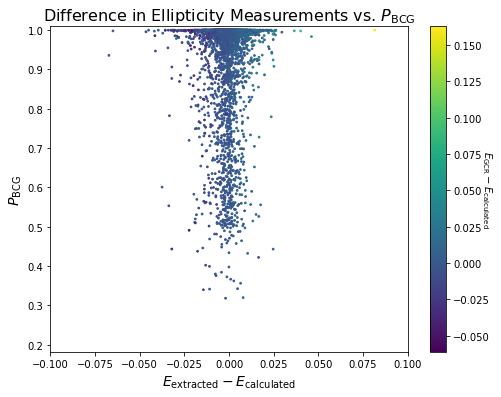

In [253]:
# get some distribution statistics
e_diff_mean = np.mean(e_diffs)
e_diff_med = np.median(e_diffs)
e_diff_stdev = np.std(e_diffs)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + e_diff_mean
x_med = 0*y + e_diff_med
x_1sigma = 0*y + e_diff_stdev
x_2sigma = 0*y + 2*e_diff_stdev
x_3sigma = 0*y + 3*e_diff_stdev

print("The mean difference in dask ellipticity measurements is", e_diff_mean)
print("The median difference in dask ellipticity measurements is", e_diff_med)
print("The standard deviation of dask e_diffs is", e_diff_stdev)

# with E_gcr - E_calculated as colorbar

plt.figure(figsize=(8,6))
plt.scatter(e_diffs
            , test_e_merged_table['p_cen_0']
            , c=e_diffs_gcr_calc
            , cmap='viridis'
            , s=3)

'''
plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

#plt.legend(loc='lower right')
plt.xlabel(r'$E_{\rm extracted} - E_{\rm calculated}$', fontsize=14)
plt.ylabel(r'$P_{\rm BCG}$', fontsize=14)
plt.xlim(-.1, .1)
plt.ylim(0.18, 1.01)

plt.title(r'Difference in Ellipticity Measurements vs. $P_{\rm BCG}$', fontsize=16)
plt.colorbar().set_label(r'$E_{\rm GCR} - E_{\rm calculated}$', rotation=270)
plt.show()